[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amingolnari/BTCUSD-PricePrediction/blob/main/BTCUSD-PricePred-5min-TensorFlowProb-demo.ipynb)

In [1]:
import numpy as np
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

In [2]:
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from keras.layers import Activation, TimeDistributed, Flatten
from keras.models import Model

In [3]:
from IPython.display import clear_output
%pip install yfinance
clear_output()

In [4]:
import yfinance as yf

In [5]:
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow_probability.python.distributions import Normal

In [6]:
def download_price_data(timezone = None, date_format = '%Y-%m-%d %H:%M'):
    d = yf.download(tickers = 'BTC-USD', 
                    start = datetime.now() - timedelta(days = 60) + timedelta(minutes = 5), 
                    end = datetime.now(), interval = '5m')
    d = (d.tz_convert(timezone)).rename(columns = {'Adj Close': 'AdjClose'}).copy(deep = True)
    d['Datetime'] = pd.date_range(start = datetime.strftime(d.index[0], date_format), periods = len(d), freq = '5min')
    d['Datetime'] = d['Datetime'].dt.strftime(date_format)
    d.set_index('Datetime', inplace = True)
    print(f'Downloaded from {d.index[0]} to {d.index[-1]} with total {len(d.index)} samples')
    return d

In [7]:
iran_timezone = pytz.timezone(zone = 'Iran')
dateformat = '%Y-%m-%d %H:%M'

In [8]:
data = download_price_data(timezone = iran_timezone, date_format = dateformat)

[*********************100%***********************]  1 of 1 completed
Downloaded from 2022-06-25 18:45 to 2022-08-24 18:40 with total 17280 samples


In [9]:
((data.head()).append(pd.DataFrame({x: '...' for x in list(data.columns)}, index = ['...']))).append(data.tail())

,Open,High,Low,Close,AdjClose,Volume
2022-06-25 18:45,21194.003906,21194.003906,21194.003906,21194.003906,21194.003906,0
2022-06-25 18:50,21194.964844,21194.964844,21194.964844,21194.964844,21194.964844,0
2022-06-25 18:55,21150.871094,21150.871094,21150.871094,21150.871094,21150.871094,0
2022-06-25 19:00,21118.226562,21118.226562,21118.226562,21118.226562,21118.226562,3856384
2022-06-25 19:05,21117.134766,21118.962891,21117.134766,21118.962891,21118.962891,0
...,...,...,...,...,...,...
2022-08-24 18:20,21458.712891,21458.712891,21450.306641,21458.341797,21458.341797,1216512
2022-08-24 18:25,21463.009766,21463.009766,21437.917969,21440.449219,21440.449219,6246400
2022-08-24 18:30,21440.835938,21457.121094,21440.835938,21449.632812,21449.632812,0
2022-08-24 18:35,21441.998047,21441.998047,21420.388672,21420.388672,21420.388672,0


In [10]:
plt.rcParams.update({'figure.figsize': [18, 6],
                     'font.size':       16, 
                     'axes.titlesize':  16, 
                     'axes.labelsize':  16, 
                     'xtick.labelsize': 16, 
                     'ytick.labelsize': 16, 
                     'legend.fontsize': 16})

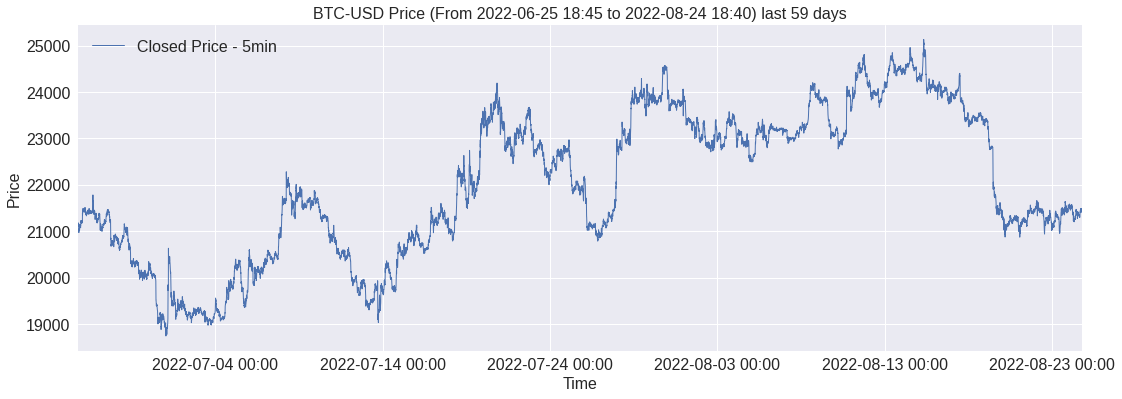

In [11]:
dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index]

plt.gca().xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
plt.plot(dates, list(data['Close']), label = 'Closed Price - 5min', linewidth = 1)
plt.xlim([dates[0], dates[-1]])
plt.title('BTC-USD Price (From {} to {}) last {} days'
.format(data.index[0], data.index[-1], (datetime.strptime(data.index[-1], dateformat) - datetime.strptime(data.index[0], dateformat)).days))
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
def normalize(x_, minmax):
    return (x_ - minmax[0]) / (minmax[1] - minmax[0])

def denormalize(x_, minmax):
    return minmax[0] + ((minmax[1] - minmax[0]) * x_)

In [13]:
def lstm_model_prob(shape):
    rg = tf.keras.regularizers.l1(l1 = 1e-3)
    I = Input(shape = shape, name = 'close_price')
    h = LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = Dense(units = 32, activation = 'sigmoid', kernel_regularizer = rg, bias_regularizer = rg)(h)
    O = DistributionLambda(lambda t: Normal(loc = t, scale = 1e-3 * tf.math.softplus(t), validate_args = True, allow_nan_stats = False))(h)
    return Model(inputs = I, outputs = O, name = 'lstm_model_prob')

In [14]:
def lstm_model(shape):
    rg = tf.keras.regularizers.l1(l1 = 1e-3)
    I = Input(shape = shape, name = 'close_price')
    h = LSTM(units = 256, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = Dense(units = 32, kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Dropout(rate = .2)(h)
    h = Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg)(h)
    h = BatchNormalization()(h)
    O = Activation('sigmoid')(h)
    return Model(inputs = I, outputs = O, name = 'lstm_model')

In [15]:
def lstm_model_timed(shape):
    rg = tf.keras.regularizers.l1(l1 = 1e-3)
    I = Input(shape = shape, name = 'close_price')
    h = LSTM(units = 256, return_sequences = True, kernel_regularizer = rg, bias_regularizer = rg, recurrent_regularizer = rg)(I)
    h = BatchNormalization()(h)
    h = TimeDistributed(Dense(units = 32, kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Dropout(rate = .2)(h)
    h = TimeDistributed(Dense(units = 1, kernel_regularizer = rg, bias_regularizer = rg))(h)
    h = BatchNormalization()(h)
    h = Flatten()(h)
    O = Activation('sigmoid')(h)
    return Model(inputs = I, outputs = O, name = 'lstm_model_timed')

In [16]:
Close_price = pd.Series.to_numpy(data['Close'])
analysis_duration = 32
data_len = Close_price.shape[0]
train_len = int((.7 * data_len) // analysis_duration * analysis_duration)
test_len = int(data_len - train_len)
close_minmax = np.array([.8 * Close_price.min(), 1.2 * Close_price.max()], dtype = 'int32')
Close_price = Close_price.reshape((data_len, 1)).astype('float32')
Close_price = normalize(Close_price, close_minmax)

In [17]:
def split_data(training_len = None, testing_len = None, analyzing_duration = None):
    train_X, train_y = [], []
    for idx in range(training_len - analyzing_duration):
        train_X.append(Close_price[idx:analyzing_duration + idx].reshape(analyzing_duration))
        train_y.append(Close_price[idx + analyzing_duration])
    train_X, train_y = np.asarray(train_X).reshape((len(train_X), analyzing_duration, 1)), np.asarray(train_y)
    test_X, test_y = [], []
    for idx in range(training_len - analyzing_duration, training_len + testing_len - analyzing_duration):
        test_X.append(Close_price[idx:analyzing_duration + idx].reshape(analyzing_duration))
        test_y.append(Close_price[idx + analyzing_duration])
    test_X, test_y = np.asarray(test_X).reshape((len(test_X), analyzing_duration, 1)), np.asarray(test_y)
    return train_X, train_y, test_X, test_y

In [18]:
def plot_prediction(y_train, y_test, y_pred, whole_data = True):
    plt.rcParams.update({'figure.figsize': [18, 6]})
    if whole_data:
        a, b, c = [], [], []
        a.extend(denormalize(y_train, close_minmax))
        a.extend([np.nan] * len(y_test))
        b.extend([np.nan] * len(y_train))
        b.extend(denormalize(y_test, close_minmax))
        c.extend([np.nan] * len(y_train))
        c.extend(denormalize(y_pred.mean(axis = 1), close_minmax))
        dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index[:-analysis_duration]]

        fig, ax = plt.subplots(1)

        ax.xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
        ax.plot(dates, a, label = 'Train', linewidth = 1)
        ax.plot(dates, b, label = 'Test', linewidth = 1)
        ax.plot(dates, c, label = 'Prediction', alpha = .8, linewidth = 1, linestyle = '-.')
    else:
        dates = [mdate.date2num(datetime.fromtimestamp(datetime.strptime(d, dateformat).timestamp())) for d in data.index[-len(y_test):]]

        fig, ax = plt.subplots(1)

        ax.xaxis.set_major_formatter(mdate.DateFormatter(dateformat))
        ax.plot(dates, denormalize(y_test, close_minmax), label = 'Test', color = 'k', linewidth = 1)
        ax.plot(dates, denormalize(y_pred.mean(axis = 1), close_minmax), label = 'Prediction', color = 'r', linewidth = 1)
        if y_pred.shape[1] > 1:
            ax.fill_between(dates, denormalize(y_pred.mean(axis = 1) + 2 * y_pred.std(axis = 1), close_minmax),
                            denormalize(y_pred.mean(axis = 1) - 2 * y_pred.std(axis = 1), close_minmax),
                            alpha = .25, label = 'Prediction Bounds', color = 'c')
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_title('Full-Trained Model (BTCUSD-PricePred-5min)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.tick_params(axis = 'x', rotation = 15)
    ax.legend()
    plt.show()

In [19]:
def plot_history(h):
    plt.rcParams.update({'figure.figsize': [18, 4]})
    m_name = h.model.name
    fig, ax = plt.subplots(1)
    for k in list(h.history.keys()):
        y = h.history[k]
        x = np.arange(1, len(y) +1, dtype = np.int)
        ax.plot(x, y, label = k.replace('_', ' '), linewidth = 2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (log)')
    ax.set_yscale('log')
    ax.set_title(str(np.char.upper(m_name.replace('_', ' '))) + ' (BTCUSD-PricePred-5min)')
    plt.legend()
    plt.show()

In [20]:
X_train, y_train, X_test, y_test = split_data(training_len = train_len, testing_len = test_len, analyzing_duration = analysis_duration)

In [21]:
val_split = .2
epochs = 30
batch_size = 32
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)

In [22]:
K.clear_session()
model = lstm_model(shape = X_train.shape[1:])
model.compile(optimizer = opt, loss = 'mae', metrics = ['mse'])
model.summary(line_length = 140)

Model: "lstm_model"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                                  Output Shape                                            Param #              
 close_price (InputLayer)                                      [(None, 32, 1)]                                         0                    
                                                                                                                                            
 lstm (LSTM)                                                   (None, 256)                                             264192               
                                                                                                                                            
 batch_normalization (BatchNormalization)                      (None, 256)                                             1024           

In [23]:
model_history = model.fit(X_train, y_train,
                          epochs = epochs,
                          batch_size = batch_size,
                          validation_split = val_split)

Epoch 1/30
302/302 [==============================] - 7s 11ms/step - loss: 1.1058 - mse: 0.0179 - val_loss: 0.4156 - val_mse: 0.0234
Epoch 2/30
302/302 [==============================] - 3s 8ms/step - loss: 0.2566 - mse: 0.0064 - val_loss: 0.2920 - val_mse: 0.0174
Epoch 3/30
302/302 [==============================] - 4s 14ms/step - loss: 0.1412 - mse: 8.2308e-04 - val_loss: 0.1666 - val_mse: 0.0072
Epoch 4/30
302/302 [==============================] - 5s 15ms/step - loss: 0.0699 - mse: 5.1244e-04 - val_loss: 0.0763 - val_mse: 0.0017
Epoch 5/30
302/302 [==============================] - 4s 14ms/step - loss: 0.0513 - mse: 5.0813e-04 - val_loss: 0.0682 - val_mse: 0.0013
Epoch 6/30
302/302 [==============================] - 4s 14ms/step - loss: 0.0494 - mse: 4.6608e-04 - val_loss: 0.0383 - val_mse: 4.4220e-05
Epoch 7/30
302/302 [==============================] - 4s 14ms/step - loss: 0.0481 - mse: 4.4117e-04 - val_loss: 0.0341 - val_mse: 1.0853e-05
Epoch 8/30
302/302 [======================

In [24]:
y_pred = model.predict(X_test)

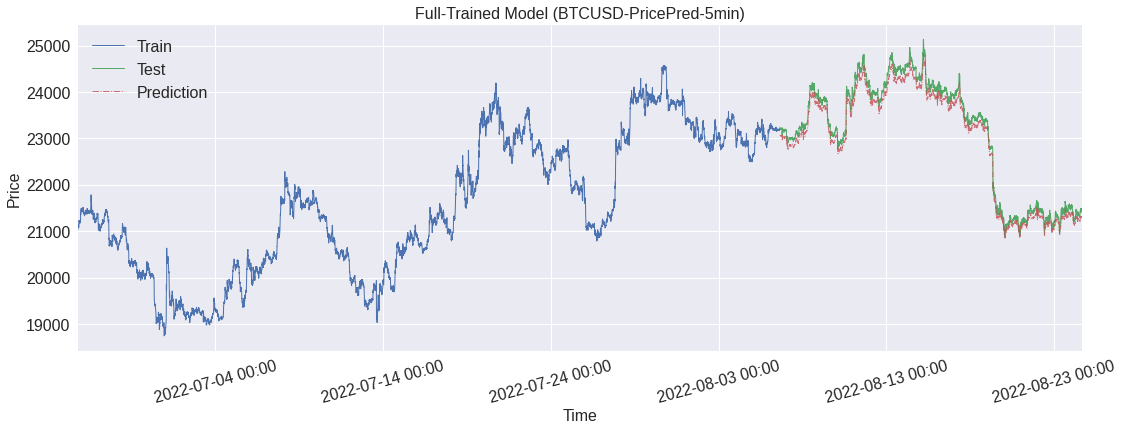

In [25]:
plot_prediction(y_train, y_test, y_pred, whole_data = True)

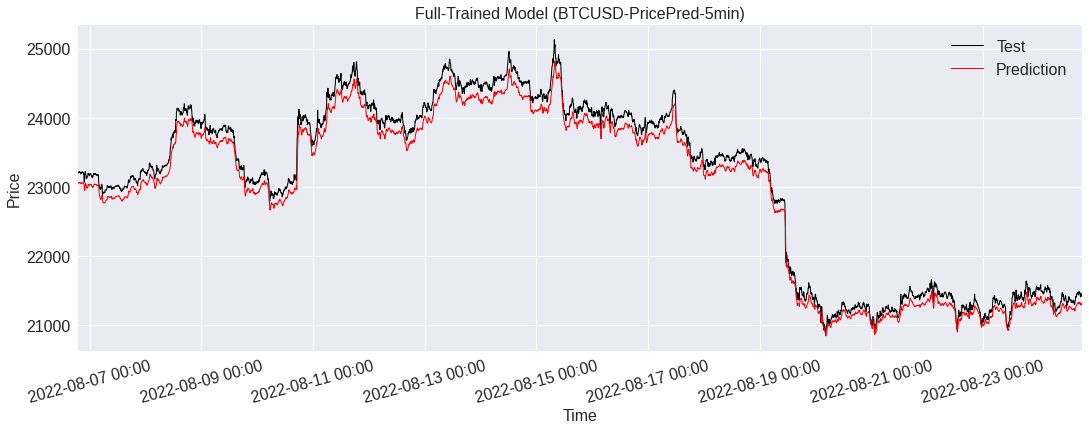

In [26]:
plot_prediction(y_train, y_test, y_pred, whole_data = False)

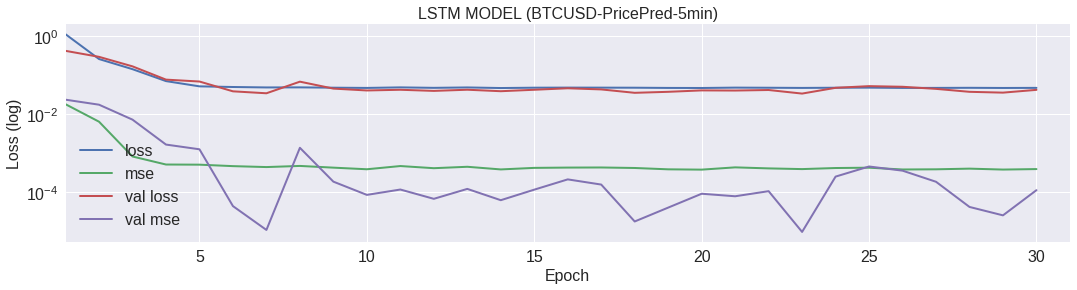

In [27]:
plot_history(model_history)

In [28]:
K.clear_session()
model = lstm_model_timed(shape = X_train.shape[1:])
model.compile(optimizer = opt, loss = 'mae', metrics = ['mse'])
model.summary(line_length = 140)

Model: "lstm_model_timed"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                                  Output Shape                                            Param #              
 close_price (InputLayer)                                      [(None, 32, 1)]                                         0                    
                                                                                                                                            
 lstm (LSTM)                                                   (None, 32, 256)                                         264192               
                                                                                                                                            
 batch_normalization (BatchNormalization)                      (None, 32, 256)                                         1024     

In [29]:
model_history_timed = model.fit(X_train, y_train,
                                epochs = epochs,
                                batch_size = batch_size,
                                validation_split = val_split)

Epoch 1/30
302/302 [==============================] - 5s 10ms/step - loss: 0.5280 - mse: 0.0054 - val_loss: 0.2538 - val_mse: 0.0242
Epoch 2/30
302/302 [==============================] - 4s 13ms/step - loss: 0.0799 - mse: 6.5771e-04 - val_loss: 0.1812 - val_mse: 0.0192
Epoch 3/30
302/302 [==============================] - 3s 10ms/step - loss: 0.0605 - mse: 6.2852e-04 - val_loss: 0.0819 - val_mse: 0.0020
Epoch 4/30
302/302 [==============================] - 3s 8ms/step - loss: 0.0556 - mse: 6.1955e-04 - val_loss: 0.0481 - val_mse: 2.8479e-04
Epoch 5/30
302/302 [==============================] - 3s 9ms/step - loss: 0.0532 - mse: 6.0121e-04 - val_loss: 0.0416 - val_mse: 1.2981e-04
Epoch 6/30
302/302 [==============================] - 3s 8ms/step - loss: 0.0509 - mse: 5.6113e-04 - val_loss: 0.0480 - val_mse: 3.4106e-04
Epoch 7/30
302/302 [==============================] - 3s 9ms/step - loss: 0.0505 - mse: 5.7742e-04 - val_loss: 0.0531 - val_mse: 5.6410e-04
Epoch 8/30
302/302 [=============

In [30]:
y_pred_timed = model.predict(X_test)

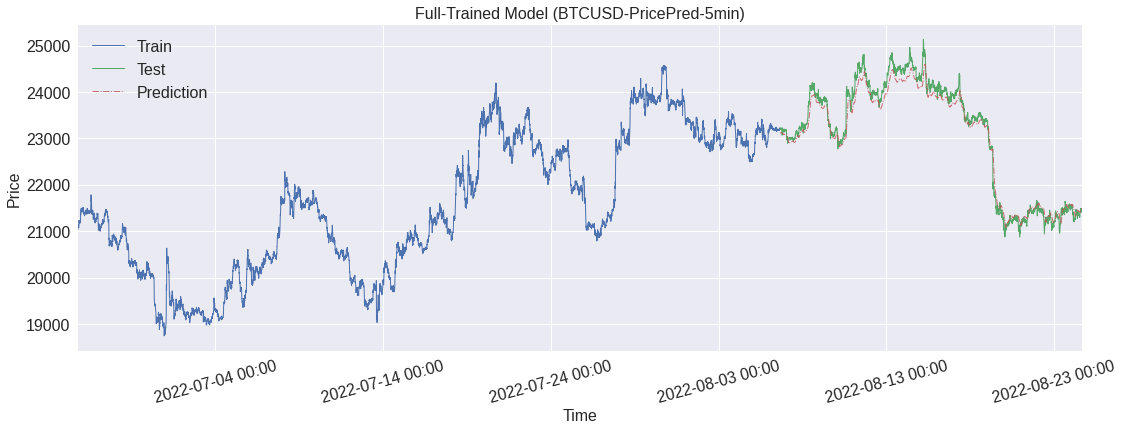

In [31]:
plot_prediction(y_train, y_test, y_pred_timed, whole_data = True)

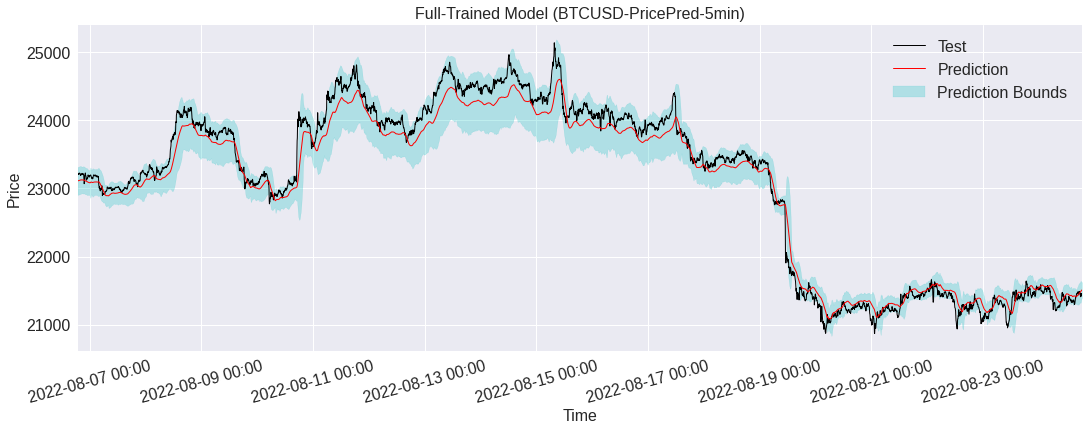

In [32]:
plot_prediction(y_train, y_test, y_pred_timed, whole_data = False)

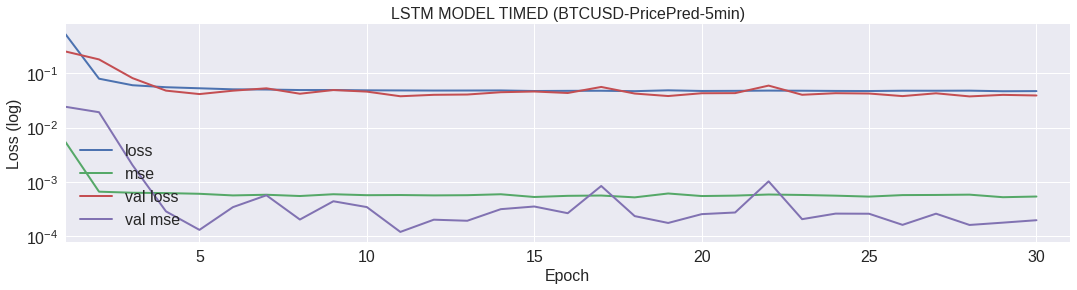

In [33]:
plot_history(model_history_timed)

In [34]:
K.clear_session()
model = lstm_model_prob(shape = X_train.shape[1:])
model.compile(optimizer = opt, loss = lambda y, p: -p.log_prob(y), metrics = ['mse'])
model.summary(line_length = 140)

Model: "lstm_model_prob"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                                  Output Shape                                            Param #              
 close_price (InputLayer)                                      [(None, 32, 1)]                                         0                    
                                                                                                                                            
 lstm (LSTM)                                                   (None, 256)                                             264192               
                                                                                                                                            
 batch_normalization (BatchNormalization)                      (None, 256)                                             1024      

In [35]:
model_history_prob = model.fit(X_train, y_train, 
                               epochs = epochs, 
                               batch_size = batch_size, 
                               validation_split = val_split)

Epoch 1/30
302/302 [==============================] - 5s 10ms/step - loss: 345.2502 - mse: 6.1678e-04 - val_loss: 9649.4258 - val_mse: 0.0166
Epoch 2/30
302/302 [==============================] - 2s 8ms/step - loss: 180.0328 - mse: 3.0009e-04 - val_loss: 2556.9226 - val_mse: 0.0048
Epoch 3/30
302/302 [==============================] - 2s 8ms/step - loss: 143.2940 - mse: 2.3891e-04 - val_loss: 63.2887 - val_mse: 1.2737e-04
Epoch 4/30
302/302 [==============================] - 2s 7ms/step - loss: 157.9953 - mse: 2.6488e-04 - val_loss: 77.0554 - val_mse: 1.5864e-04
Epoch 5/30
302/302 [==============================] - 2s 8ms/step - loss: 152.8826 - mse: 2.5698e-04 - val_loss: 84.6071 - val_mse: 1.7651e-04
Epoch 6/30
302/302 [==============================] - 2s 8ms/step - loss: 130.3561 - mse: 2.2022e-04 - val_loss: 59.7959 - val_mse: 1.2428e-04
Epoch 7/30
302/302 [==============================] - 2s 8ms/step - loss: 161.1489 - mse: 2.7256e-04 - val_loss: 53.9463 - val_mse: 1.1341e-04
Ep

In [36]:
y_pred_prob = model.predict(X_test)

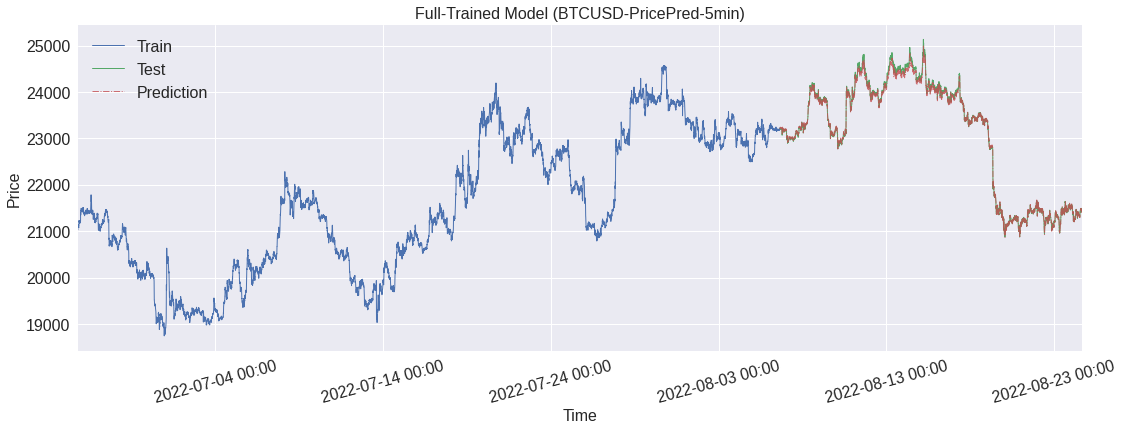

In [37]:
plot_prediction(y_train, y_test, y_pred_prob, whole_data = True)

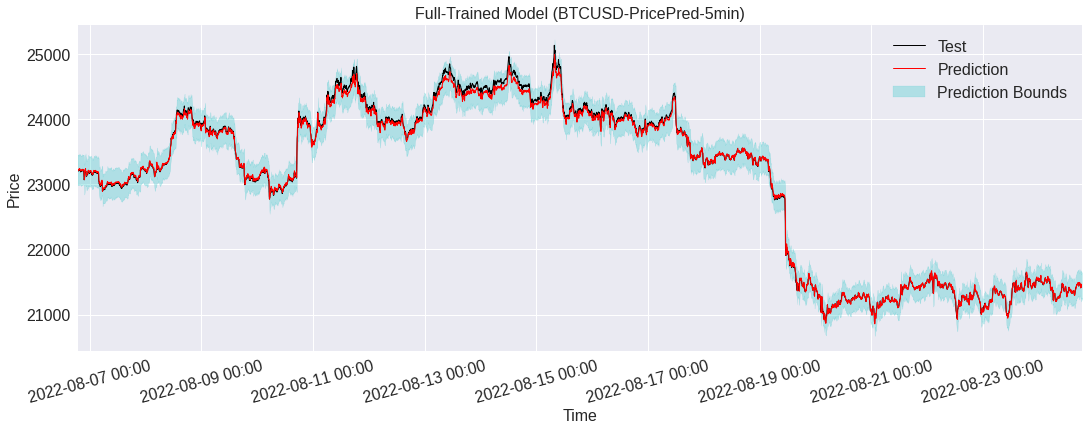

In [38]:
plot_prediction(y_train, y_test, y_pred_prob, whole_data = False)

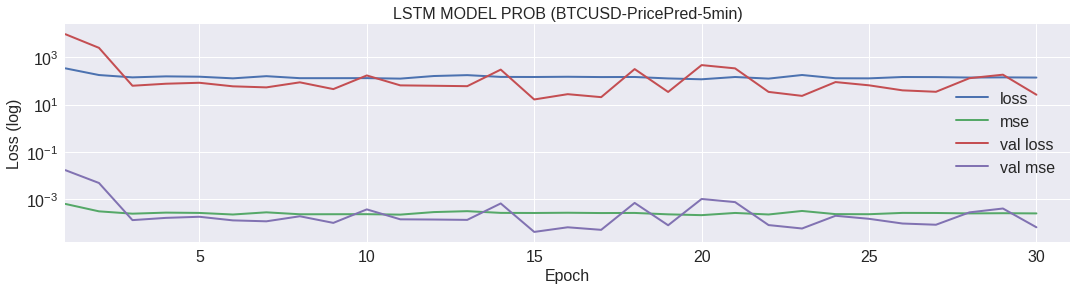

In [39]:
plot_history(model_history_prob)